In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pyresample
import numpy as np

print(tf.__version__)

2.0.0


In [2]:
train_file_path = 'train.csv'
test_file_path = 'test.csv'

column_names = ['date', 'in_out', 'latitude', 'longitude',
                '6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff', '18~20_ride']
column_names_test = ['date', 'in_out', 'latitude', 'longitude',
                '6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff']

train_raw = pd.read_csv(train_file_path, usecols=column_names,
                        na_values='?', skipinitialspace=True)
test_raw = pd.read_csv(test_file_path, usecols=column_names_test,
                       na_values='?', skipinitialspace=True)

In [3]:
train_raw.tail()

,date,in_out,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,18~20_ride
415418,2019-09-30,시내,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,2019-09-30,시내,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,2019-09-30,시내,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
415421,2019-09-30,시내,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,2019-09-30,시내,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [4]:
LON = np.linspace(train_raw['longitude'].min(), train_raw['longitude'].max(), 50)
LAT = np.linspace(train_raw['latitude'].min(), train_raw['latitude'].max(), 50)

# 제일 거리가 가까운 grid 인덱스 찾기
def geo_idx(dd, dd_array):
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

def make_dataset(df):
    dataset = df.copy()
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['weekday'] = dataset['date'].dt.weekday
    
    # 주말 데이터
    dataset['weekend'] = (dataset['weekday'] >= 5).astype(float)
    
    # 휴일 데이터
    holidays = pd.to_datetime(['2019-09-12', '2019-09-13', '2019-09-14', 
                           '2019-10-03', '2019-10-09'])
    dataset['holidays'] = dataset['date'].isin(holidays)*1.0
    
    # 요일 one hot encoding
    dataset['mon'] = (dataset['weekday'] == 0)*1.0
    dataset['tue'] = (dataset['weekday'] == 1)*1.0
    dataset['wed'] = (dataset['weekday'] == 2)*1.0
    dataset['thu'] = (dataset['weekday'] == 3)*1.0
    dataset['fri'] = (dataset['weekday'] == 4)*1.0
    dataset['sat'] = (dataset['weekday'] == 5)*1.0
    dataset['sun'] = (dataset['weekday'] == 6)*1.0
    
    # 필요 없는 칼럼 지우기
    dataset.drop(['date', 'weekday'], 1, inplace=True)
    
    in_out = dataset.pop('in_out')
    dataset['in'] = (in_out == '시내')*1.0
    dataset['out'] = (in_out == '시외')*1.0
    
    dataset['grid_lon'] = dataset['longitude'].map(lambda x: geo_idx(x, LON))
    dataset['grid_lat'] = dataset['latitude'].map(lambda x: geo_idx(x, LAT))
    
#     dataset = pd.get_dummies(dataset, columns=['grid_lon', 'grid_lat'])
    dataset.drop(['latitude', 'longitude'], 1, inplace=True)
    
    return dataset

In [5]:
train_dataset = make_dataset(train_raw)
train_labels = train_dataset.pop('18~20_ride')
test_dataset = make_dataset(test_raw)
train_dataset.tail()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,...,tue,wed,thu,fri,sat,sun,in,out,grid_lon,grid_lat
415418,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,13
415419,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21,19
415420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,1
415421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,17
415422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21,3


In [6]:
grid_lon_index = train_dataset['grid_lon']
grid_lat_index = train_dataset['grid_lat']

def make_mesh_grid(lon, lat):
    df = np.zeros((50, 50))
    print(f'lat: {lat}, lon: {lon}')
    df[lat, lon] = 3
    return df

grid = []
grid_lon_index

0         20
1         20
2         19
3         20
4         15
          ..
415418     6
415419    21
415420     6
415421     9
415422    21
Name: grid_lon, Length: 415423, dtype: int64

In [7]:
set(train_dataset.columns) - set(test_dataset.columns)

set()

In [8]:
test_dataset['grid_lat_47'] = 0

In [9]:
test_dataset.tail()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,...,wed,thu,fri,sat,sun,in,out,grid_lon,grid_lat,grid_lat_47
228165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,6,0
228166,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10,16,0
228167,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6,13,0
228168,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,21,19,0
228169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,21,3,0


In [10]:
numeric_columns = [
    '6~7_ride', '7~8_ride', '8~9_ride',
    '9~10_ride', '10~11_ride', '11~12_ride',
    '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
    '9~10_takeoff', '10~11_takeoff'
]

categorical_columns = train_dataset.columns.difference(numeric_columns)

train_stats = train_dataset.describe()
train_stats.drop(categorical_columns, 1, inplace=True)
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
6~7_ride,415423.0,0.305893,1.109766,0.0,0.0,0.0,0.0,85.0
7~8_ride,415423.0,0.829699,2.255116,0.0,0.0,0.0,1.0,94.0
8~9_ride,415423.0,0.815350,2.317561,0.0,0.0,0.0,1.0,136.0
9~10_ride,415423.0,0.642475,1.959844,0.0,0.0,0.0,1.0,78.0
10~11_ride,415423.0,0.599618,1.885941,0.0,0.0,0.0,0.0,124.0
11~12_ride,415423.0,0.579393,1.942137,0.0,0.0,0.0,0.0,99.0
6~7_takeoff,415423.0,0.112870,0.597714,0.0,0.0,0.0,0.0,45.0
7~8_takeoff,415423.0,0.344870,1.279179,0.0,0.0,0.0,0.0,66.0
8~9_takeoff,415423.0,0.516481,1.658850,0.0,0.0,0.0,0.0,59.0
9~10_takeoff,415423.0,0.430922,1.485124,0.0,0.0,0.0,0.0,65.0


In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset[numeric_columns])
normed_train_data[categorical_columns] = train_dataset[categorical_columns]
normed_test_data = norm(test_dataset[numeric_columns])
normed_test_data[categorical_columns] = test_dataset[categorical_columns]

In [12]:
normed_train_data= normed_train_data.apply(lambda x: np.log(x+1))
normed_test_data= normed_test_data.apply(lambda x: np.log(x+1))

In [13]:
normed_train_data.tail()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,...,holidays,in,mon,out,sat,sun,thu,tue,wed,weekend
415418,1.465273,-0.458737,-0.433577,-0.397229,-0.382639,-0.354288,-0.209286,-0.314167,-0.373020,-0.342715,...,0.0,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,1.465273,-0.458737,-0.433577,-0.397229,-0.382639,-0.354288,-0.209286,-0.314167,-0.373020,-0.342715,...,0.0,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,-0.322463,-0.458737,-0.433577,-0.397229,-0.382639,-0.354288,-0.209286,0.413532,-0.373020,-0.342715,...,0.0,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415421,0.485787,-0.458737,-0.433577,-0.397229,-0.382639,-0.354288,-0.209286,-0.314167,-0.373020,-0.342715,...,0.0,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,-0.322463,-0.458737,-0.433577,-0.397229,-0.382639,-0.354288,-0.209286,-0.314167,1.131389,-0.342715,...,0.0,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
len(train_dataset.keys())

24

In [15]:
model = keras.Sequential([         
    layers.Dense(256, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

In [17]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [18]:
normed_train_data.shape

(415423, 24)

In [19]:
train_labels

0          0.0
1          5.0
2          2.0
3         53.0
4          0.0
          ... 
415418     0.0
415419     0.0
415420     0.0
415421     0.0
415422     0.0
Name: 18~20_ride, Length: 415423, dtype: float64

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 2s - loss: 14.1321 - mae: 1.2699 - mse: 14.1321 - val_loss: 9.7545 - val_mae: 1.0615 - val_mse: 9.7545
Epoch 2/1000
332338/332338 - 1s - loss: 12.8572 - mae: 1.2278 - mse: 12.8572 - val_loss: 9.3587 - val_mae: 1.4071 - val_mse: 9.3587
Epoch 3/1000
332338/332338 - 1s - loss: 12.5422 - mae: 1.2229 - mse: 12.5422 - val_loss: 8.9670 - val_mae: 1.0908 - val_mse: 8.9670
Epoch 4/1000
332338/332338 - 1s - loss: 12.2859 - mae: 1.2180 - mse: 12.2859 - val_loss: 9.2255 - val_mae: 1.2000 - val_mse: 9.2255
Epoch 5/1000
332338/332338 - 1s - loss: 12.1815 - mae: 1.2200 - mse: 12.1815 - val_loss: 9.0667 - val_mae: 1.1664 - val_mse: 9.0667
Epoch 6/1000
332338/332338 - 1s - loss: 11.9561 - mae: 1.2024 - mse: 11.9561 - val_loss: 9.2255 - val_mae: 1.1062 - val_mse: 9.2255
Epoch 7/1000
332338/332338 - 1s - loss: 11.8321 - mae: 1.2031 - mse: 11.8321 - val_loss: 8.7198 - val_mae: 1.1753 - val_mse: 8.7198
Epoch 8/1000
332338/33233

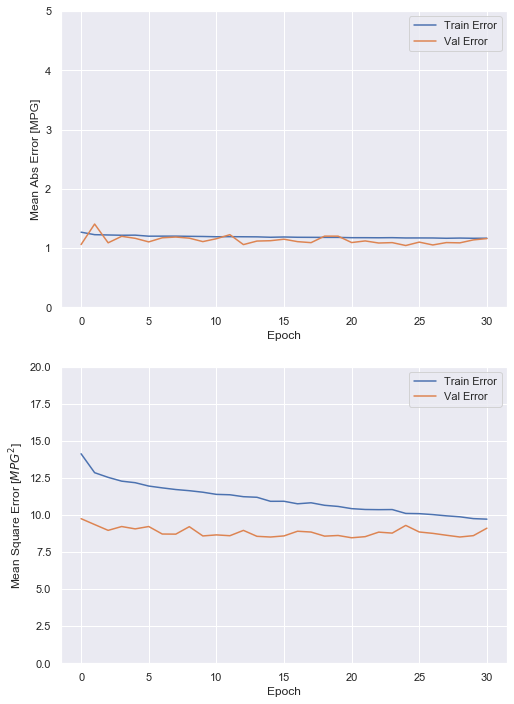

In [20]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000
history = model.fit(np.array(normed_train_data), np.array(train_labels), epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=2, callbacks=[early_stop])

plot_history(history)

In [21]:
predictions = model.predict(normed_test_data)

In [22]:
predictions.flatten()

array([10.078686 , 10.7136545,  4.3820696, ...,  0.3450809,  0.5972868,
        0.3401422], dtype=float32)

In [23]:
submission_path = 'submission_sample.csv'
submission = pd.read_csv(submission_path)
submission['18~20_ride'] = predictions.flatten()
submission.to_csv("submission_3.csv", index=False)

In [24]:
submission.tail()

,id,18~20_ride
228165,643588,-0.250615
228166,643589,0.168463
228167,643590,0.345081
228168,643591,0.597287
228169,643592,0.340142
